# Trend Model

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

# Path Management

In [2]:
path = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\data\PXFront"
spx_path  = os.path.join(path, "ES.parquet")

# Make Signature Plot

In [3]:
def prep_data(path: str) -> pd.DataFrame:

    df_out = (pd.read_parquet(
        path = path, engine = "pyarrow").
        assign(date = lambda x: pd.to_datetime(x.date)).
        drop(columns = ["security"]).
        rename(columns = {"PX_LAST": "price"}).
        set_index("date"))
    
    return df_out

df_spx = prep_data(spx_path)

In [4]:
def get_all_data() -> pd.DataFrame:
    
    full_path = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\data\PXFront"
    paths = [os.path.join(full_path, path) for path in os.listdir(full_path) if path != "NG.parquet" and path != "UX.parquet"]
    dfs = pd.concat([prep_data(path).assign(security = path.split("\\")[-1].split(".")[0]) for path in paths])
    
    return dfs

df_all = get_all_data()

In [5]:
def get_signature_plot(df: pd.DataFrame) -> pd.DataFrame: 
    
    rtns = df.pct_change().price.dropna()
    timesteps = [int(i + 1) for i in range(200)]
    stds = [
        (rtns.rolling(window = timestep).std().mean()) / rtns.std()
        for timestep in timesteps]

    df_signature = (pd.DataFrame({
        "timestep": timesteps,
        "stds": stds}).
        dropna().
        set_index("timestep"))
    
    return df_signature

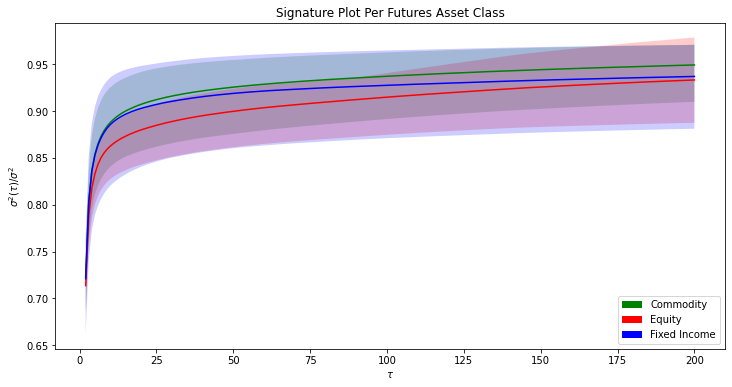

In [29]:
def make_singature_plot(df_all: pd.DataFrame) -> plt.Figure: 

    df_signature_plot = (df_all.groupby(
        "security").
        apply(get_signature_plot).
        reset_index())

    path        = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\root\fut_tickers.xlsx"
    bad_tickers = ["SFR", "SER", "FF"] 
    
    df_kind = (pd.read_excel(
        io = path, sheet_name = "px")
        [["contract", "kind"]].
        rename(columns = {"contract": "security"}).
        query("security != @bad_tickers"))

    df_combined = (df_signature_plot.merge(
        right = df_kind, how = "inner",on = ["security"]))

    colors = {
        "Commodity": "Green",
        "Equity": "Red",
        "Fixed Income": "Blue"}

    legend_elements = [Patch(facecolor = colors[security_kind], label = security_kind) for security_kind in colors.keys()]
    fig, axes = plt.subplots(figsize = (12,6))
    for contract_kind in colors.keys():

        df_plot = (df_combined.query(
            "kind == @contract_kind").
            drop(columns = ["kind"]).
            pivot(index = "timestep", columns = "security", values = "stds"))

        df_minmax = (df_plot.reset_index().melt(
            id_vars = "timestep").
            drop(columns = ["security"]).
            groupby("timestep").
            agg(["min", "max"])
            ["value"])

        axes.fill_between(
            x = df_minmax.index,
            y1 = df_minmax["min"],
            y2 = df_minmax["max"],
            alpha = 0.2,
            facecolor = colors[contract_kind])

        df_plot.mean(axis = 1).plot(color = colors[contract_kind])

        axes.legend(handles = legend_elements, loc = "lower right")
        axes.set_xlabel(r"$\tau$")
        axes.set_ylabel(r"$\sigma^2(\tau)/\sigma^2$")
        axes.set_title("Signature Plot Per Futures Asset Class")
        
make_singature_plot(df_all)

# Prepping Time Series

We are going to normalize the returns of the strategy to make strategies unit variance. They use a method to get the EWMA of daily volatility. <br>
$$
\begin{equation}
\sigma_t := \gamma \sqrt{\mathcal{L}_{\tau_{\sigma}}[D_t^2]}
\end{equation}
$$
Then apply that to the Returns $R_t$
$$
\begin{equation}
R_t = \frac{D_t}{\sigma_{t-1}}
\end{equation}
$$
They authors set these parameters as $\gamma = 1.05$ and $\tau_{\sigma} = 10$.

In [7]:
def _get_norm_rt(df: pd.DataFrame, tau: int = 10, gamma: float =  1.05) -> pd.DataFrame: 
    
    df_out = (df_spx.assign(
        px_diff = lambda x: x.price.diff(),
        vol = lambda x: x.px_diff.ewm(span = tau, adjust = False).std() * gamma,
        r_t = lambda x: x.px_diff / x.vol.shift()))
    
    return df_out

df_rtn = _get_norm_rt(df_spx)

# Simple Trend Model

The authors begin with the following relationship between the performance of the trend and the variance of the returns.

$$
\begin{aligned}
\mathcal{G}_T &= \sum_{t = 1}^T G_t\\
            &=\frac{\lambda}{2} \left( \left( \sum_{t=1}^T R_t \right)^2 - \sum_{t=1}^T R_t^2 \right)\\
\end{aligned}
$$

They use a trend following signal on prior returns $\mathcal{L}_{\tau}(R_t)$. An analog relationship follows <br>
\begin{equation}
\mathcal{L}_{\tau'}[G_t] = \frac{\lambda \tau}{\tau - 1} \left( \tau \mathcal{L}_{\tau}^2[R_t] - \mathcal{L}_{\tau'}[R_t^2]\right) 
\end{equation}
Where $\tau'$ follows <br>
\begin{align}
\tau' &= \frac{\tau}{2} + \frac{1}{2\tau}\\
&\thickapprox \frac{\tau}{2}
\end{align}

Let's make a simple trend following model with EWMA. The authors set lookback windows using 5 days, 20 days, 60 days for weekly, monthly, and bi-annually.

In [8]:
def _make_prediction(df: pd.DataFrame, window: int, lambda_: float = 0.001) -> pd.DataFrame: 

    lambda_val = lambda_ / np.sqrt(window)
    df_rtn = _get_norm_rt(df)
    
    df_prediction = (df_rtn.dropna().assign(
        window = window, 
        left_side = lambda x: (np.sign(
            x.r_t.ewm(span = window, adjust = False).mean().shift()) * x.r_t).
            cumsum(),
        right_side = lambda x: 1000 * lambda_val * (
            window / (window - 1) * 
            (
                (window * (x.r_t.ewm(span = window, adjust = False).mean() ** 2)).cumsum() - 
                ((x.r_t ** 2).ewm(span = window / 2, adjust = False).mean()).cumsum())))
        [["left_side", "right_side", "window"]])
    
    return df_prediction

def make_prediction(df_rtn: pd.DataFrame, lookbacks: list = [5, 20, 60]) -> pd.DataFrame: 
    
    df_predictions = pd.concat([_make_prediction(df_rtn, window) for window in lookbacks])
    return df_predictions

df_predictions = make_prediction(df_spx)

With respect to the plots there are some caveats. Putting each side of the equation on seperate axes leads to some scaling problems. To show this create seperate lookback windows. There is also a slight problem with the EWMA on the beginning dates that have to be artificially sliced out (to be technical its around 30 points). 

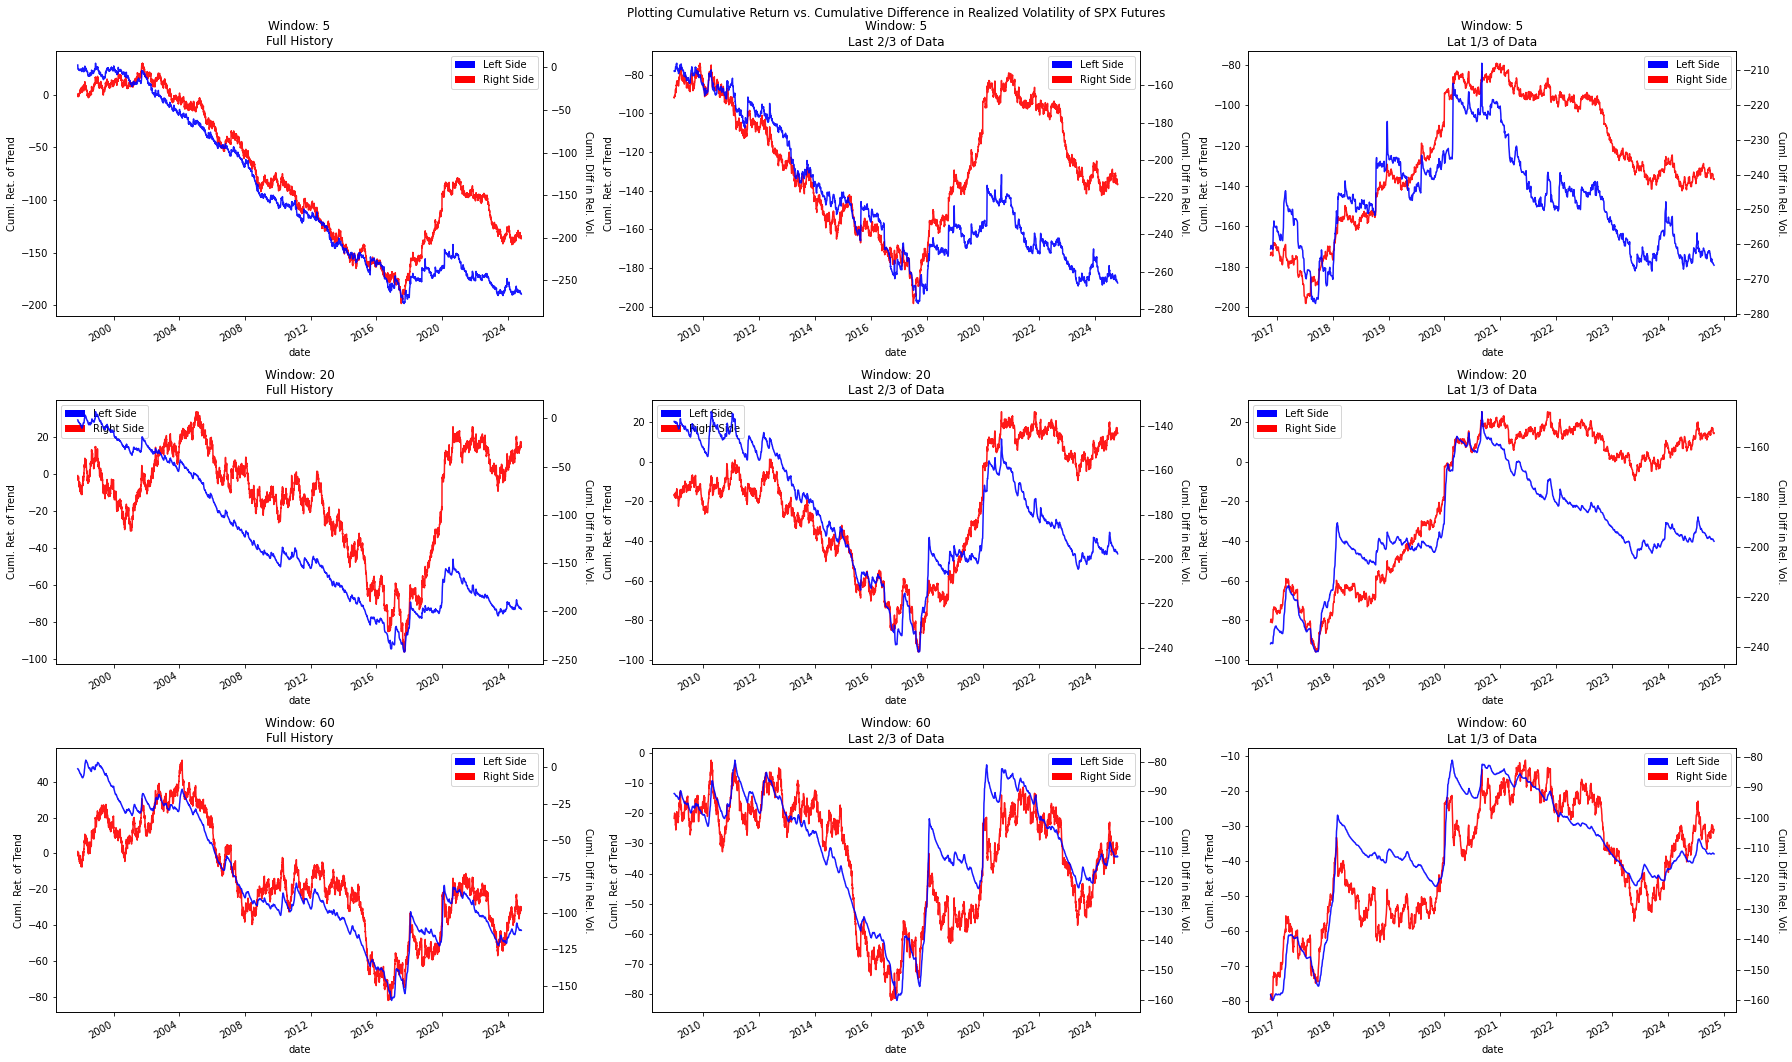

In [9]:
def _tmp_plot(df_tmp: pd.DataFrame, i: int, j: int, window: int, ax, name):
    
    ax_copy = ax[i,j].twinx()
    
    (df_tmp.left_side.plot(
        ax = ax[i,j],
        color = "red",
        alpha = 0.9))
    
    (df_tmp.right_side.plot(
        ax = ax_copy,
        color = "blue",
        alpha = 0.9,
        title = "Window: {}\n{}".format(window, name)))
    
    color_dict = {
        "Left Side": "Blue",
        "Right Side": "Red"}
    
    legend_elements = [Patch(facecolor = color_dict[security_kind], label = security_kind) for security_kind in color_dict.keys()]

    ax[i,j].set_ylabel("Cuml. Ret. of Trend")
    ax_copy.set_ylabel("Cuml. Diff in Rel. Vol.", rotation = 270, labelpad = 15)
    
    ax[i,j].legend(handles = legend_elements)
    
def plot_predictions(df_predictions: pd.DataFrame) -> plt.Figure: 
    
    lookbacks = df_predictions.window.drop_duplicates().to_list()

    right_ylabel = r"$\frac{\lambda \tau}{\tau - 1} \left( \tau \mathcal{L}_{\tau}^2[R_t] - \mathcal{L}_{\tau'}[R_t^2]\right)$" 
    left_ylabel = r"$\mathcal{L}_{\tau'}[G_t]$"

    title_namer = {
        4_000: "Last 2/3 of Data",
        2_000: "Lat 1/3 of Data"}

    fig, axes = plt.subplots(ncols = len(lookbacks), nrows = 3, figsize = (25,15))
    for i, lookback in enumerate(lookbacks): 

        df_tmp = (df_predictions.query(
            "window == @lookback").
            drop(columns = ["window"]).
            iloc[30:])

        _tmp_plot(df_tmp, i, 0, lookback, axes, "Full History")
        _tmp_plot(df_tmp.tail(4_000), i, 1, lookback, axes, title_namer[4_000])
        _tmp_plot(df_tmp.tail(2_000), i, 2, lookback, axes, title_namer[2_000])

    fig.suptitle("Plotting Cumulative Return vs. Cumulative Difference in Realized Volatility of SPX Futures")
    plt.tight_layout()
    
plot_predictions(df_predictions)

Now plot the average PnL of Trend follower vs. Signal

In [10]:
def _get_agg_signal_pnl(df_spx: pd.DataFrame, window: int = 180) -> pd.DataFrame: 

    df_agg_signal = (_get_norm_rt(df_spx).dropna().assign(
        signal = lambda x: np.sqrt(window) * x.r_t.ewm(span = window, adjust = False).mean(),
        g_t = lambda x: (np.sign(x.signal.shift()) * x.r_t).rolling(window = int(window / 2)).sum()))
    
    return df_agg_signal

def get_agg_signal_pnl(df_spx: pd.DataFrame, lookback_windows: list = [5, 20, 60, 180]) -> pd.DataFrame: 

    df_out = pd.concat(
        [_get_agg_signal_pnl(df_spx, window = lookback).assign(lookback = lookback) 
        for lookback in lookback_windows])
    
    return df_out

df_agg = get_agg_signal_pnl(df_spx)

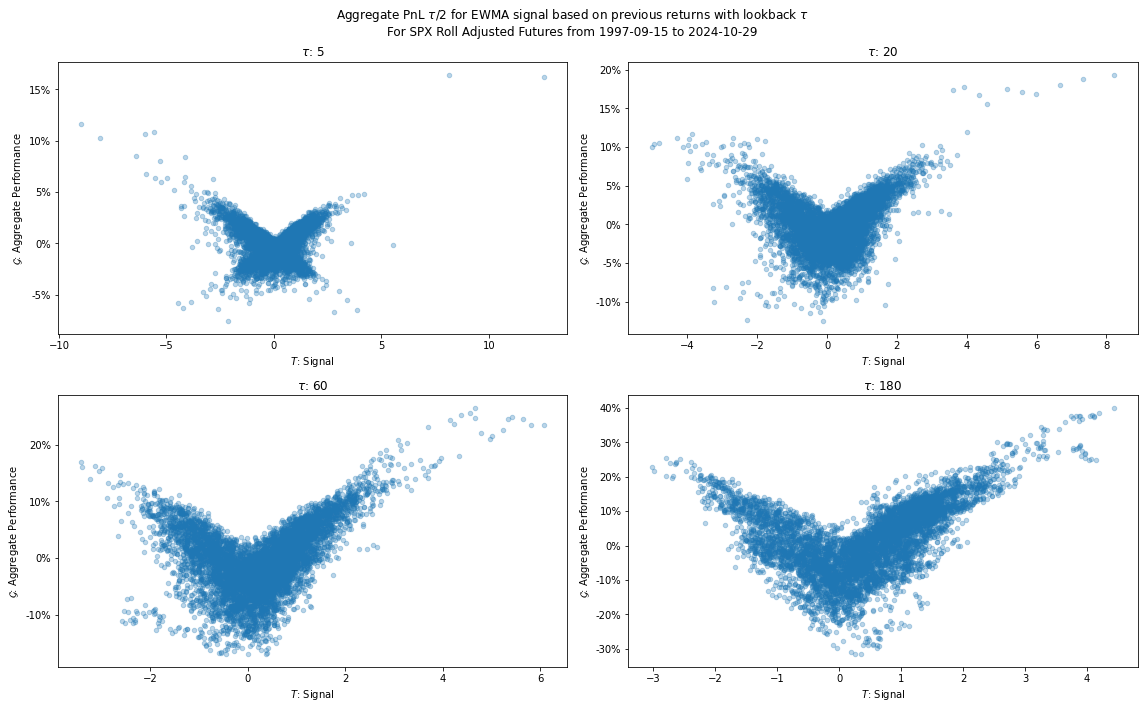

In [11]:
def plot_aggregate_pnl_vs_signal(df_agg: pd.DataFrame) -> plt.Figure: 
    
    lookbacks = df_agg.lookback.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(lookbacks) // 2, nrows = len(lookbacks) // 2, figsize = (16,10))
    xlabel = r"$T$"
    ylabel = r"$\mathcal{G}$"
    title1 = "Aggregate PnL "
    title2 = r"$\tau / 2$"
    title3 = " for EWMA signal based on previous returns with lookback "
    title4 = r"$\tau$"

    for lookback, ax in zip(lookbacks, axes.flatten()):

        (df_agg.query(
            "lookback == @lookback").
            plot(
                ax = ax,
                kind = "scatter",
                x = "signal",
                y = "g_t",
                alpha = 0.3,
                xlabel = xlabel + ": Signal",
                ylabel = ylabel + ": Aggregate Performance",
                title = r"$\tau$: {}".format(lookback)))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
        
    fig.suptitle(title1 + title2 + title3 + title4 + "\nFor SPX Roll Adjusted Futures from {} to {}".format(
        df_agg.index.min().date(),
        df_agg.index.max().date()))
    plt.tight_layout()
    
plot_aggregate_pnl_vs_signal(df_agg)

# Exponential Moving Average Crossover Trend

The following strategy is for trending following using the sign of EWMA on $R_t$, another standard trend signal is the EWMAC. Within the ***Advnaced Futures Trading Strategies*** by Robert Carver uses a EWMAC method of $4n$ for the longer window e.g. $\tau = 60 \rightarrow EWMAC(60, 240)$

In [12]:
def _apply_ewmac_trend(df: pd.DataFrame, trend_dict: dict) -> pd.DataFrame: 
    
    df_out = (df.sort_index().assign(
        long_window = lambda x: x.price.ewm(span = trend_dict["long_window"], adjust = False).mean(),
        short_window = lambda x: x.price.ewm(span = trend_dict["short_window"], adjust = False).mean(),
        signal = lambda x: (x.short_window - x.long_window) / x.price,
        lag_signal = lambda x: x.signal.shift(),
        trend_name = trend_dict["short_window"]))
    
    return df_out

def get_ewmac_trend(df_spx: pd.DataFrame, lookbacks: list = [5, 20, 60, 18], multiplier: int = 4) -> pd.DataFrame: 

    trend_windows = [{"short_window": lookback, "long_window": lookback * multiplier} for lookback in lookbacks]
    df_ewmac = pd.concat([_apply_ewmac_trend(df_spx, trend_dict) for trend_dict in trend_windows])
    
    return df_ewmac

df_ewmac = get_ewmac_trend(df_spx)

In this case using double with window length for the cumulative returns generates a more ATM straddle like payoff. 

In [13]:
def _get_agg_perf(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.assign(
        rtn = lambda x: x.price.pct_change(),
        signal_rtn = lambda x: np.sign(x.lag_signal) * x.rtn,
        cum_rtn = lambda x: x["signal_rtn"].rolling(window = df.name * 2).apply(lambda y: np.prod(1 + y) - 1, raw = True)))
    
    return df_out

def get_agg_perf(df_ewmac: pd.DataFrame) -> pd.DataFrame: 

    df_perf = (df_ewmac.groupby(
        "trend_name").
        apply(_get_agg_perf))
    
    return df_perf

df_perf = get_agg_perf(df_ewmac)

AttributeError: 'tuple' object has no attribute 'date'

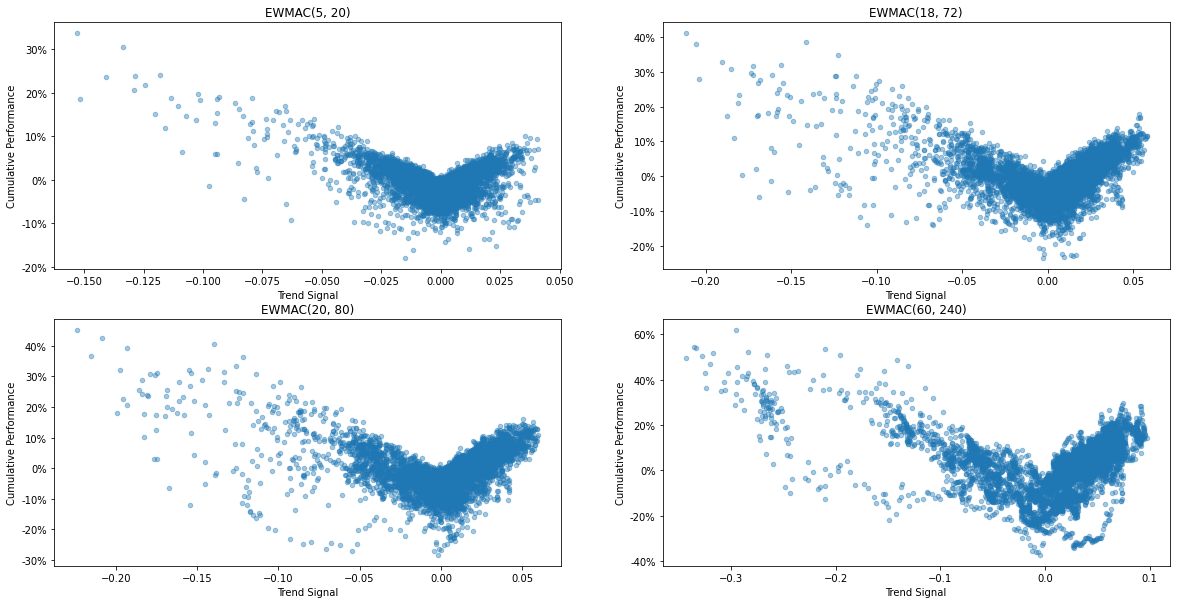

In [14]:
def plot_ewmac_perf(df_perf: pd.DataFrame) -> pd.DataFrame: 
    
    trend_windows = df_perf.trend_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(trend_windows) // 2, nrows = len(trend_windows) // 2, figsize = (20, 10))

    for trend_window, ax in zip(trend_windows, axes.flatten()): 

        (df_perf.query(
            "trend_name == @trend_window").
            assign(cum_rtn = lambda x: x.cum_rtn * 100).
            plot(
                alpha = 0.4,
                ax = ax,
                ylabel = "Cumulative Performance",
                xlabel = "Trend Signal",
                title = "EWMAC({}, {})".format(trend_window, trend_window * 4),
                kind = "scatter",
                x = "signal",
                y = "cum_rtn"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

    fig.suptitle("EWMAC Performance over double the window length vs. Trend Signal\nUsing SPX Roll Adjusted Futures from {} to {}".format(
        df_perf.index.min().date(),
        df_perf.index.max().date()))

    plt.tight_layout()
    
plot_ewmac_perf(df_perf)